# Equipo Defensivo

In [12]:
import requests
from bs4 import BeautifulSoup

TIPOS_ES = {
    "acero","agua","bicho","dragón","eléctrico","fantasma","fuego","hada","hielo",
    "lucha","normal","planta","psíquico","roca","siniestro","tierra","veneno","volador"
}

# Función para extraer estadísticas y tipos de un Pokémon desde su página
def extraer_estadisticas_y_tipos(url):
    r = requests.get(url)
    if r.status_code != 200:
        print("Error", r.status_code, url)
        return None

    soup = BeautifulSoup(r.text, "html.parser")

    # Estadísticas
    stats = {
        "PS": None, "Ataque": None, "Defensa": None,
        "At. esp.": None, "Def. esp.": None, "Velocidad": None
    }

    # Buscamos cualquier tabla que contenga filas TH/TD con esos nombres
    for tabla in soup.find_all("table"):
        filas = tabla.find_all("tr")
        for tr in filas:
            celdas = tr.find_all(["th","td"])
            if len(celdas) < 2:
                continue
            clave = celdas[0].get_text(" ", strip=True)
            valor = celdas[1].get_text(" ", strip=True)

            # Comprobamos si el contenido de la clave es una de las estadísticas que buscamos
            if clave in stats and (stats[clave] is None):
                # nos quedamos con el primer valor que encontremos
                # quitamos posibles símbolos y convertimos a int si se puede
                valnum = ''.join(ch for ch in valor if ch.isdigit())
                stats[clave] = int(valnum) if valnum.isdigit() else None

    # Buscamos los tipos del Pokémon
    tipos = []
    for span in soup.find_all("span", typeof="mw:File"):
        a = span.find("a")
        if a and a.has_attr("title"):
            tipo = a["title"].replace("Tipo ", "").lower()
            if tipo in TIPOS_ES and tipo not in tipos:
                tipos.append(tipo)

    # Máximo 2 tipos
    tipos = tipos[:2]

    # 3) Nombre (del título o de la URL)
    nombre = soup.find("h1").get_text(" ", strip=True) if soup.find("h1") else url.rstrip("/").split("/")[-1]

    return {
        "nombre": nombre,
        "tipos": tipos,
        "ps": stats["PS"],
        "ataque": stats["Ataque"],
        "defensa": stats["Defensa"],
        "ataque_esp": stats["At. esp."],
        "defensa_esp": stats["Def. esp."],
        "velocidad": stats["Velocidad"],
        "url": url
    }

In [13]:
# Equipo defensivo
import requests
from bs4 import BeautifulSoup
from tqdm import tqdm
import pandas as pd

# Función para obtener todos los pokemon de equipo fuego de entre los 250 primeros de la pokedex
def obtener_pokemons_fuego():
    url = "https://www.wikidex.net/wiki/Lista_de_Pokémon"
    response = requests.get(url)
    soup = BeautifulSoup(response.text)

    pokemons_fuego = []
    contador = 0

    tablas = soup.find_all('table', class_='tabpokemon')

    for tabla in tablas:
        filas = tabla.find_all('tr')
        for fila in filas[1:]:

            if contador >= 251:
                return pokemons_fuego

            celdas = fila.find_all('td')
            if not celdas:
                continue

            # Pokemon de Alola. Contenido de celdas: 0:nombre, 1:tipos, 2:japonés
            if len(celdas) == 3:
                celda_nombre = celdas[0]

                celda_tipos = celdas[1]

            # Pokemon normal. Contenido de celdas: 0:número, 1:nombre, 2:tipos, 3:japonés
            elif len(celdas) > 3:

                celda_nombre = celdas[1]
                celda_tipos = celdas[2]

            else:
                continue

            # Nombre y link del pokemon
            enlace_tag = celda_nombre.find('a')

            # Comprobar que la etiqueta <a> y el atributo href existan
            if enlace_tag and enlace_tag.has_attr('href'):
                enlace = enlace_tag['href']
                link_pokemon = "https://www.wikidex.net" + enlace

            if enlace_tag and enlace_tag.has_attr('title'):
                nombre = enlace_tag['title']

            contador += 1

            # Tipos del pokemon
            tipos = []
            for span in celda_tipos.find_all("span", typeof="mw:File"):
                a = span.find("a")
                if a and a.has_attr("title"):
                    # En casos como "Tipo Volador" guardamos "volador"
                    tipo = a["title"].replace("Tipo ", "").lower()
                    tipos.append(tipo)

            if "fuego" in tipos:
                pokemons_fuego.append({
                    "nombre": nombre,
                    "link": link_pokemon,
                    "tipos": tipos
                })

    return pokemons_fuego

print(f"Extrayendo pokemons de tipo fuego...", end="")
# Lista con los pokemon de tipo fuego
pokemons_fuego = obtener_pokemons_fuego()
print(f" ({len(pokemons_fuego)} encontrados)")

# Lista de los pokemons de tipo fuego con sus estadísticas
lista_pokemon_fuego = []
for pokemon in tqdm(pokemons_fuego, desc="Extrayendo estadísticas"):
    datos = extraer_estadisticas_y_tipos(pokemon['link'])
    lista_pokemon_fuego.append(datos)

# OBTENEMOS E IMPRIMIMOS EL EQUIPO DEFENSIVO.
def clave_defensiva(pokemon):
    # Orden: 1) defensa → 2) vida (PS) → 3) ataque
    return (pokemon['defensa'], pokemon['ps'], pokemon['ataque'])

def obtener_equipo_defensivo(lista_pokemon_fuego):
    lista_ordenada = sorted(lista_pokemon_fuego, key=clave_defensiva, reverse=True)
    return lista_ordenada[:6]


def imprimir_equipo_defensivo(equipo):
    for pokemon in equipo:
        print(f"{pokemon['nombre']}\n      Defensa: {pokemon['defensa']}\n      Vida: {pokemon['ps']}\n      Ataque: {pokemon['ataque']}")
        print(f"      Ataque especial: {pokemon['ataque_esp']}\n      Defensa especial: {pokemon['defensa_esp']}\n      Velocidad: {pokemon['velocidad']}")
        print(f"      Tipos: {', '.join(pokemon['tipos'])}")

equipo_defensivo = obtener_equipo_defensivo(lista_pokemon_fuego)

df_defensivo = pd.DataFrame(equipo_defensivo)
df_defensivo = df_defensivo.sort_values(by=['defensa', 'ps', 'ataque'],ascending=[False, False, False])

print(f"\n\n=============================== EQUIPO DEFENSIVO SELECCIONADO ==============================\n")
print(df_defensivo[['nombre', 'defensa', 'ps', 'ataque', 'ataque_esp', 'defensa_esp', 'velocidad', 'tipos']].to_string(index=False))


Extrayendo pokemons de tipo fuego... (19 encontrados)


Extrayendo estadísticas: 100%|██████████| 19/19 [00:19<00:00,  1.02s/it]



=============================== EQUIPO DEFENSIVO SELECCIONADO ==============================

           nombre  defensa  ps  ataque  ataque_esp  defensa_esp  velocidad             tipos
 Marowak de Alola      110  60      80          50           80         45 [fuego, fantasma]
          Moltres       90  90     100         125           85         90  [fuego, volador]
Arcanine de Hisui       80  95     115          95           80         90     [fuego, roca]
         Arcanine       80  90     110         100           80         95   [fuego, normal]
        Charizard       78  78      84         109           85        100  [fuego, volador]
       Typhlosion       78  78      84         109           85        100   [fuego, normal]


/tmp/ipython-input-1582611751.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  grafico = sns.barplot(


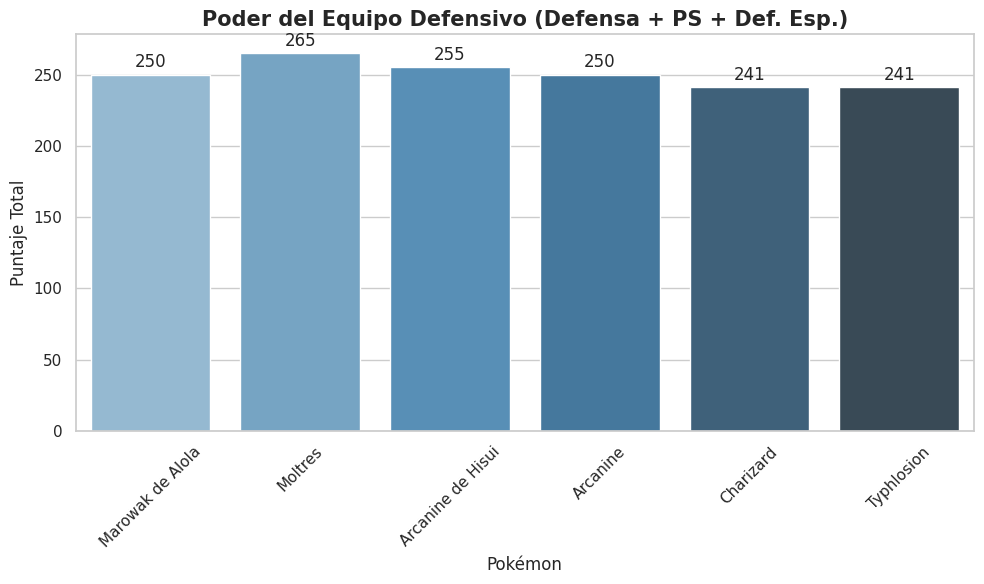

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Preparar los datos del Equipo Defensivo
data_defensivo = df_defensivo.head(6).copy()
data_defensivo['Poder Defensivo'] = data_defensivo['defensa'] + data_defensivo['ps'] + data_defensivo['defensa_esp']

# 2. Configurar la gráfica
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

# Crear el gráfico de barras
grafico = sns.barplot(
    data=data_defensivo,
    x='nombre',
    y='Poder Defensivo',
    palette='Blues_d' # Paleta de colores azules para denotar defensa
)

#Añadir etiquetas y títulos
plt.title('Poder del Equipo Defensivo (Defensa + PS + Def. Esp.)', fontsize=15, fontweight='bold')
plt.xlabel('Pokémon', fontsize=12)
plt.ylabel('Puntaje Total', fontsize=12)
plt.xticks(rotation=45)

# Añadir el valor encima de cada barra
for p in grafico.patches:
    grafico.annotate(f'{int(p.get_height())}',
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha = 'center', va = 'center',
                     xytext = (0, 9),
                     textcoords = 'offset points')

plt.tight_layout()
plt.show()

# Equipo Ofensivo

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

# Configuración


def obtener_datos_ofensivos_api():

    # 1. Obtener información general del tipo (Fuego) para optimizar llamadas
    # Esto nos da la lista de todos los movimientos de fuego y todos los pokemon de fuego
    url_type = f"https://pokeapi.co/api/v2/type/fire"
    res = requests.get(url_type)
    if res.status_code != 200:
        print("Error conectando con PokeAPI")
        return []

    data_type = res.json()

    # 2. Crear diccionario de Movimientos de Fuego y sus Poderes
    # En lugar de consultar cada movimiento por cada pokemon, creamos una caché.
    print("Analizando movimientos del tipo para calcular Poder Máximo...")
    move_powers = {}

    for move_entry in data_type['moves']:
        move_name = move_entry['name']
        move_url = move_entry['url']

        # Hacemos petición al detalle del movimiento para sacar su 'power'
        r_move = requests.get(move_url)
        if r_move.status_code == 200:
            m_data = r_move.json()
            power = m_data.get('power')
            # Solo nos interesan movimientos que tengan daño (power > 0)
            if power:
                move_powers[move_name] = power

    print(f"Movimientos de fire con daño base catalogados: {len(move_powers)}")
    #hasta aquí entendido
    # 3. Iterar sobre los Pokémon del tipo elegido
    pokemons_ofensivos = []

    for poke_entry in data_type['pokemon']:
        # Extraemos el ID de la URL para filtrar por generación (<= 251)
        # URL formato: .../pokemon/4/
        poke_id = int(poke_entry['pokemon']['url'].rstrip('/').split('/')[-1])

        if poke_id > 251: # Queremos solo los 251 primeros
            continue

        poke_name = poke_entry['pokemon']['name']
        poke_url = poke_entry['pokemon']['url']

        # Petición a los detalles del Pokémon
        r_poke = requests.get(poke_url)
        if r_poke.status_code != 200:
            continue
        p_data = r_poke.json()
#hasta aquí entendido

        # A. Obtener Estadísticas (Ataque y Ataque Especial) [cite: 35, 36]
        stats = {}

        # Recorres la lista fea
        for s in p_data['stats']:
            nombre = s['stat']['name']
            valor = s['base_stat']
            stats[nombre] = valor
        atk = stats['attack']
        sp_atk = stats['special-attack']

        # B. Buscar el movimiento más fuerte de SU tipo que el pokémon pueda aprender
        #  "Poder = Ataque especial x Daño base del ataque más potente de su tipo"
        max_move_power = 0
        best_move_name = "None"

        for move_entry in p_data['moves']:
            m_name = move_entry['move']['name']

            # Verificamos si el movimiento es de tipo fuego (está en nuestro diccionario)
            if m_name in move_powers:
                pwr = move_powers[m_name]
                if pwr > max_move_power:
                    max_move_power = pwr
                    best_move_name = m_name

        # C. Calcular el Poder según la fórmula del enunciado
        # Poder = Sp. Atk * Daño Base
        calculo_poder = sp_atk * max_move_power

        # Guardamos tipos para la fase de Sinergias
        tipos = [t['type']['name'] for t in p_data['types']]

        pokemons_ofensivos.append({
            'nombre': poke_name.capitalize(),
            'id': poke_id,
            'ataque': atk,
            'ataque_esp': sp_atk,
            'mejor_ataque_tipo': best_move_name,
            'daño_base_ataque': max_move_power,
            'poder_calculado': calculo_poder, #
            'tipos': tipos,
            'url': poke_url
        })

    return pokemons_ofensivos

# --- EJECUCIÓN ---
lista_ofensiva = obtener_datos_ofensivos_api()

# Convertimos a DataFrame para facilitar el ordenamiento y visualización
df_ofensivo = pd.DataFrame(lista_ofensiva)

# ORDENAR EL EQUIPO [cite: 34, 35, 36, 37]
# Criterios: 1. Ataque Especial, 2. Ataque, 3. Poder
df_ofensivo = df_ofensivo.sort_values(
    by=['ataque_esp', 'ataque', 'poder_calculado'],
    ascending=[False, False, False]
)

# Seleccionar los 6 mejores
equipo_ofensivo = df_ofensivo.head(6).copy()

print("\n=== EQUIPO OFENSIVO SELECCIONADO ===")
print(equipo_ofensivo[['nombre', 'ataque_esp', 'ataque', 'poder_calculado', 'mejor_ataque_tipo']].to_string(index=False))

# Transformar a lista de diccionarios para compatibilidad con tu código de sinergias anterior
lista_equipo_ofensivo = equipo_ofensivo.to_dict('records')

Analizando movimientos del tipo para calcular Poder Máximo...
Movimientos de fire con daño base catalogados: 41

=== EQUIPO OFENSIVO SELECCIONADO ===
    nombre  ataque_esp  ataque  poder_calculado mejor_ataque_tipo
   Moltres         125     100            16250          overheat
     Ho-oh         110     130            14300          overheat
  Houndoom         110      90            14300          overheat
 Charizard         109      84            16350        blast-burn
Typhlosion         109      84            16350          eruption
  Arcanine         100     110            13000          overheat


/tmp/ipython-input-3090008994.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  grafico = sns.barplot(


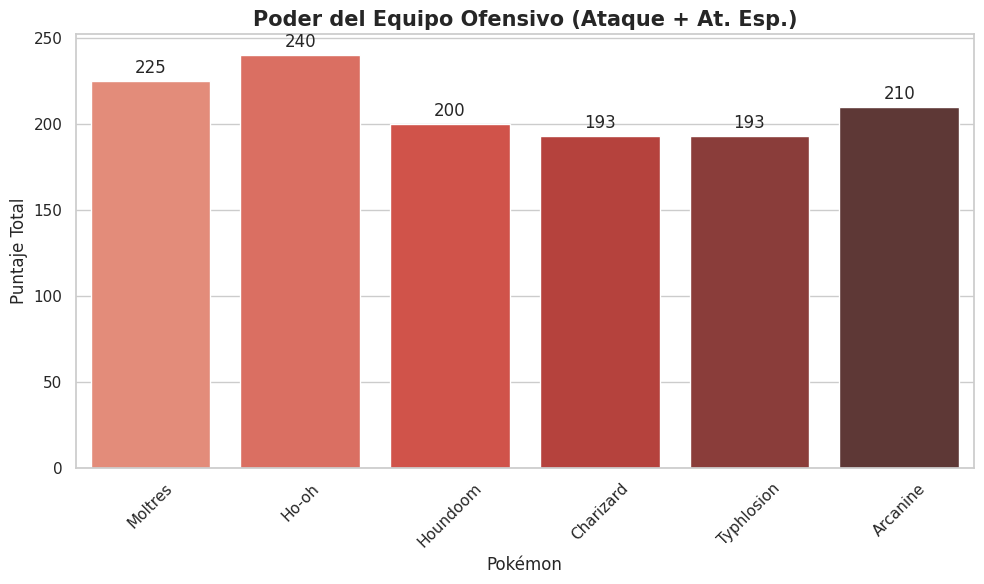

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Preparar los datos del Equipo Ofensivo
data_ofensivo = equipo_ofensivo.head(6).copy()
data_ofensivo['Poder Ofensivo'] = data_ofensivo['ataque'] + data_ofensivo['ataque_esp']

# 2. Configurar la gráfica
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

# Crear el gráfico de barras
grafico = sns.barplot(
    data=data_ofensivo,
    x='nombre',
    y='Poder Ofensivo',
    palette='Reds_d' # Paleta de colores rojos para denotar ataque
)

# 3. Añadir etiquetas y títulos
plt.title('Poder del Equipo Ofensivo (Ataque + At. Esp.)', fontsize=15, fontweight='bold')
plt.xlabel('Pokémon', fontsize=12)
plt.ylabel('Puntaje Total', fontsize=12)
plt.xticks(rotation=45)

for p in grafico.patches:
    grafico.annotate(f'{int(p.get_height())}',
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha = 'center', va = 'center',
                     xytext = (0, 9),
                     textcoords = 'offset points')

plt.tight_layout()
plt.show()

# Sinergía de Tipos

In [ ]:
# ==============================================
# PARTE 1 — DICCIONARIO + FUNCIÓN + NORMALIZACIÓN
# ==============================================

# 1. Diccionario inglés → español
TIPOS_ENG2ESP = {
    "fire": "fuego",
    "water": "agua",
    "rock": "roca",
    "flying": "volador",
    "dragon": "dragón",
    "dark": "siniestro",
    "ghost": "fantasma",
    "normal": "normal",
    "grass": "planta",
    "electric": "eléctrico",
    "ice": "hielo",
    "steel": "acero",
    "fairy": "hada",
    "fighting": "lucha",
    "ground": "tierra",
    "poison": "veneno",
    "bug": "bicho",
    "psychic": "psíquico"
}

# 2. Función para convertir tipos de un equipo al español
def convertir_tipos_a_espanol(lista_pokemon):
    for p in lista_pokemon:
        nuevos_tipos = []
        for t in p["tipos"]:
            if t in TIPOS_ENG2ESP:     # si está en inglés → traducimos
                nuevos_tipos.append(TIPOS_ENG2ESP[t])
            else:                      # si ya está en español → se queda igual
                nuevos_tipos.append(t)
        p["tipos"] = nuevos_tipos


# 3. Funciones de normalización
def normalizar_equipo_defensivo(equipo_def):
    equipo_norm = []
    for p in equipo_def:
        equipo_norm.append({
            "nombre": p["nombre"],
            "tipos": p["tipos"],
            "score": (p["defensa"] or 0) + (p["ps"] or 0) + (p["defensa_esp"] or 0),
            "origen": "defensivo",
            "datos": p
        })
    return equipo_norm


def normalizar_equipo_ofensivo(equipo_of):
    equipo_norm = []
    for p in equipo_of:
        equipo_norm.append({
            "nombre": p["nombre"],
            "tipos": p["tipos"],
            "score": (p["ataque_esp"] or 0) + (p["ataque"] or 0),
            "origen": "ofensivo",
            "datos": p
        })
    return equipo_norm


# 4. Normalizamos ambos equipos
equipo_def_norm = normalizar_equipo_defensivo(equipo_defensivo)
equipo_of_norm = normalizar_equipo_ofensivo(lista_equipo_ofensivo)

# 5. Convertimos tipos al español (muy importante)
convertir_tipos_a_espanol(equipo_def_norm)
convertir_tipos_a_espanol(equipo_of_norm)

# 6. Unimos ambos equipos para sinergias
lista_para_sinergias = equipo_def_norm + equipo_of_norm

print("Ejemplo de Pokémon normalizado y traducido:")
print(lista_para_sinergias[0])


Ejemplo de Pokémon normalizado y traducido:
{'nombre': 'Marowak de Alola', 'tipos': ['fuego', 'fantasma'], 'score': 250, 'origen': 'defensivo', 'datos': {'nombre': 'Marowak de Alola', 'tipos': ['fuego', 'fantasma'], 'ps': 60, 'ataque': 80, 'defensa': 110, 'ataque_esp': 50, 'defensa_esp': 80, 'velocidad': 45, 'url': 'https://www.wikidex.net/wiki/Marowak_de_Alola'}}


In [ ]:
def contar_tipos_equipo(equipo):
    tipos = set()
    for p in equipo:
        tipos.update(p["tipos"])
    return tipos


def calcular_tipos_nuevos(pokemon, tipos_cubiertos):
    return set(pokemon["tipos"]) - tipos_cubiertos


def elegir_mejor_pokemon(candidatos, tipos_cubiertos):
    mejor = None
    mejor_ganancia = -1
    mejor_score = -1

    for p in candidatos:
        ganancia = len(calcular_tipos_nuevos(p, tipos_cubiertos))
        if ganancia > mejor_ganancia or (ganancia == mejor_ganancia and p["score"] > mejor_score):
            mejor = p
            mejor_ganancia = ganancia
            mejor_score = p["score"]

    return mejor


def actualizar_equipo_y_tipos(equipo_final, tipos_cubiertos, pokemon):
    equipo_final.append(pokemon)
    tipos_cubiertos.update(pokemon["tipos"])


def construir_equipo_sinergias(lista_pokemon, k=6):
    equipo_final = []
    tipos_cubiertos = set()
    candidatos = lista_pokemon.copy()

    while len(equipo_final) < k and candidatos:
        mejor = elegir_mejor_pokemon(candidatos, tipos_cubiertos)
        if mejor is None:
            break
        actualizar_equipo_y_tipos(equipo_final, tipos_cubiertos, mejor)
        candidatos.remove(mejor)

    return equipo_final, tipos_cubiertos


# Ejecución del algoritmo
equipo_sinergias, tipos_cubiertos = construir_equipo_sinergias(lista_para_sinergias)

print("================= EQUIPO FINAL POR SINERGIAS ==================")
for p in equipo_sinergias:
    print(f"- {p['nombre']} ({', '.join(p['tipos'])}) | origen: {p['origen']} | score: {p['score']}")

print("\nTipos cubiertos por el equipo:")
print(", ".join(sorted(tipos_cubiertos)))

================= EQUIPO FINAL POR SINERGIAS ==================
- Moltres (fuego, volador) | origen: defensivo | score: 265
- Arcanine de Hisui (fuego, roca) | origen: defensivo | score: 255
- Marowak de Alola (fuego, fantasma) | origen: defensivo | score: 250
- Arcanine (fuego, normal) | origen: defensivo | score: 250
- Houndoom (siniestro, fuego) | origen: ofensivo | score: 200
- Charizard (fuego, volador) | origen: defensivo | score: 241

Tipos cubiertos por el equipo:
fantasma, fuego, normal, roca, siniestro, volador


/tmp/ipython-input-3423536166.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  grafico = sns.barplot(


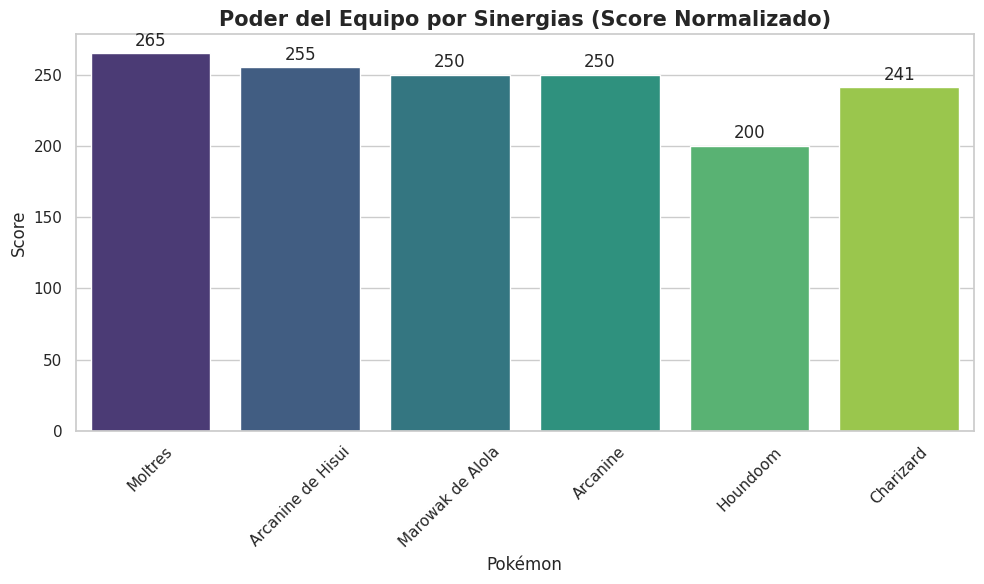

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Preparar los datos del Equipo de Sinergias
df_sinergias = pd.DataFrame(equipo_sinergias)

# 2. Configurar la gráfica
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

# Crear el gráfico de barras
grafico = sns.barplot(
    data=df_sinergias,
    x='nombre',
    y='score',
    palette='viridis' # Paleta variada para denotar mezcla/sinergia
)

# 3. Añadir etiquetas y títulos
plt.title('Poder del Equipo por Sinergias (Score Normalizado)', fontsize=15, fontweight='bold')
plt.xlabel('Pokémon', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.xticks(rotation=45)

# Añadir el valor encima de cada barra
for p in grafico.patches:
    grafico.annotate(f'{int(p.get_height())}',
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha = 'center', va = 'center',
                     xytext = (0, 9),
                     textcoords = 'offset points')

plt.tight_layout()
plt.show()

# Elección de ataques mediante modelo NLP

In [ ]:
import requests
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


# Tipos que usaremos para entrenar el modelo
TIPOS_ENTRENAMIENTO = ["water", "grass", "psychic", "rock", "normal", "dark", "electric", "ground", "fairy", "steel", "poison"]

# Función para obtener la descripción en inglés de un movimiento
def obtener_descripcion_movimiento(move_data, language="en"):
    entries = move_data.get("flavor_text_entries", [])
    for e in entries:
        if e["language"]["name"] == language:
            return e["flavor_text"].replace("\n", " ").replace("\f", " ")
    return ""

# Función para crear el dataset de movimientos que vamos a usar para entrenar el modelo
def crear_dataset_movimientos():
    movimientos = []

    for tipo in TIPOS_ENTRENAMIENTO:
        url_type = f"https://pokeapi.co/api/v2/type/{tipo}"
        res = requests.get(url_type)
        if res.status_code != 200:
            print("Error al conectar con PokeAPI para tipo", tipo)
            continue

        data_type = res.json()

        for move_entry in tqdm(data_type["moves"], desc=f"Cargando movimientos tipo {tipo}", unit="mov"):
            move_name = move_entry["name"]
            move_url = move_entry["url"]

            r_move = requests.get(move_url)
            if r_move.status_code != 200:
                continue

            m_data = r_move.json()
            power = m_data.get("power", None)
            move_type = m_data["type"]["name"]
            descripcion = obtener_descripcion_movimiento(m_data, language="en")
            damage_class = m_data["damage_class"]["name"]  # 'physical', 'special', 'status'

            movimientos.append({
                "nombre": move_name,
                "tipo": move_type,
                "power": power,
                "damage_class": damage_class,
                "text": descripcion
            })

    df_movs = pd.DataFrame(movimientos)
    print("Total de movimientos recogidos:", len(df_movs))
    return df_movs

print(f"Creando el dataset de movimientos para entrenamiento...\n")
df_movimientos = crear_dataset_movimientos()

print(f"\nEntrenando modelo de clasificación de movimientos defensivos...")
# Etiquetamos movimientos como defensivos (1) o no defensivos (0)
def marcar_defensivo(fila):
    desc = (fila["text"] or "").lower()
    damage_class = fila["damage_class"]

    palabras_defensa = [
        "raise defense", "raises defense", "raise special defense", "raises special defense",
        "lower attack", "lowers attack",
        "protect", "barrier", "shield", "guard",
        "wall", "substitute", "reduce damage", "less damage",
        "boosts", "heightens", "heals", "raise resistance", "raises resistance",
        "cure", "restores", "recovers", "recover", "healing", "regains", "restores",
        "steals HP", "prevents", "increases the user's", "raises the user's", "Ups SPCL.DEF",
        "increases user's", "raises user's", "Raises SP. ATK and SP. DEF", "Raises the SPCL. ATK",
        "maximize ATTACK", "ensures", "charges up", "preventing", "user is roused", "user eats", "user sharpens",
        "user concentrates", "user focuses", "user covers itself", "user shields itself", "user braces", "user endures",
        "increases the users"

    ]

    if damage_class == "status":
        for palabra in palabras_defensa:
            if palabra.lower() in desc.lower():
                return 1

    return 0

df_movimientos["class"] = df_movimientos.apply(marcar_defensivo, axis=1)

# Función de limpieza de texto
def limpiar_texto(texto):
    # Pasamos a minúsculas
    texto = (texto or "").lower()
    # Eliminamos caracteres que no sean letras
    texto = re.sub(r"[^a-z\s]", "", texto)
    # Eliminamos espacios extra
    texto = re.sub(r"\s+", " ", texto).strip()
    return texto

# Creamos columna con el texto limpio
df_movimientos["text_clean"] = df_movimientos["text"].apply(limpiar_texto)

# Dividimos en train y test
X = df_movimientos["text_clean"]
y = df_movimientos["class"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Vectorización TF-IDF
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Modelo de Regresión Logística
model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_train_vec, y_train)

# Predicciones
y_pred = model.predict(X_test_vec)

# Evaluación
print("\nAccuracy en test:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred))

def predecir_defensivo(df_moves, vectorizer, model):
    # Limpiar texto
    df_moves["text_clean"] = df_moves["text"].apply(limpiar_texto)
    # Vectorizar
    X_vec = vectorizer.transform(df_moves["text_clean"])
    # Predecir
    df_moves["is_defensive"] = model.predict(X_vec)
    return df_moves
predecir_defensivo(df_movimientos, vectorizer, model)

# Función para seleccionar los mejores movimientos de un pokemon
def seleccionar_mejores_movimientos(df_pokemon_moves):
    # Separamos defensivos y ofensivos
    defensivos = df_pokemon_moves[df_pokemon_moves["is_defensive"] == 1]
    ofensivos = df_pokemon_moves[df_pokemon_moves["is_defensive"] == 0]

    # Elegimos 1 defensivo (el de mayor power si tiene power, o cualquiera si NaN)
    if not defensivos.empty:
        defensivo_elegido = defensivos.sort_values("power", ascending=False).iloc[0:1]
    else:
        defensivo_elegido = pd.DataFrame()  # por si no hay defensivos

    # Elegimos los 3 ofensivos de mayor power
    ofensivos = ofensivos.sort_values("power", ascending=False).head(3)

    mejores = pd.concat([defensivo_elegido, ofensivos])

    mejores = mejores.reset_index(drop=True)
    return mejores[["nombre", "tipo", "power", "damage_class", "text", "is_defensive"]]

# Mapa de nombres para llamar a la API a partir del nombre del equipo de sinergías.
mapa_nombres_api = {
    "Charmander": "charmander",
    "Charmeleon": "charmeleon",
    "Charizard": "charizard",
    "Vulpix": "vulpix",
    "Ninetales": "ninetales",
    "Growlithe": "growlithe",
    "Growlithe de Hisui": "growlithe-hisui",
    "Arcanine": "arcanine",
    "Arcanine de Hisui": "arcanine-hisui",
    "Ponyta": "ponyta",
    "Rapidash": "rapidash",
    "Marowak de Alola": "marowak-alola",
    "Magmar": "magmar",
    "Flareon": "flareon",
    "Moltres": "moltres",
    "Cyndaquil": "cyndaquil",
    "Quilava": "quilava",
    "Typhlosion": "typhlosion",
    "Typhlosion de Hisui": "typhlosion-hisui"
}

# Función para crear el dataset de movimientos de un Pokémon específico
def crear_dataset_movimientos_por_pokemon(pokemon):
    movimientos = []

    nombre = pokemon["nombre"]
    print(f"\nDescargando movimientos de {nombre}...")
    nombre_api = mapa_nombres_api.get(nombre, nombre.lower())
    url = f"https://pokeapi.co/api/v2/pokemon/{nombre_api}"
    res = requests.get(url)
    if res.status_code != 200:
        print("Error al obtener datos de", nombre)

    data = res.json()

    for move_entry in data["moves"]:
        move_name = move_entry["move"]["name"]
        move_url = move_entry["move"]["url"]

        r_move = requests.get(move_url)
        if r_move.status_code != 200:
            continue

        m_data = r_move.json()
        power = m_data.get("power", None)
        move_type = m_data["type"]["name"]
        damage_class = m_data["damage_class"]["name"]
        descripcion = obtener_descripcion_movimiento(m_data)

        movimientos.append({
            "nombre": move_name,
            "tipo": move_type,
            "power": power,
            "damage_class": damage_class,
            "text": limpiar_texto(descripcion)
        })

    df_movs = pd.DataFrame(movimientos)
    print("Total de movimientos recogidos:", len(df_movs))
    return df_movs

# Ejecución para el equipo final
movimientos_finales_equipo = {}

print(f"\nClasificando y seleccionando movimientos para el equipo final...\n")
for pokemon in equipo_sinergias:
    df_moves_pokemon = crear_dataset_movimientos_por_pokemon(pokemon)
    df_moves_pokemon = predecir_defensivo(df_moves_pokemon, vectorizer, model)
    mejores_movs = seleccionar_mejores_movimientos(df_moves_pokemon)

    movimientos_finales_equipo[pokemon["nombre"]] = mejores_movs

    print(f"Mejores movimientos para {pokemon['nombre']}:")
    print(mejores_movs.to_string(index=False))


Creando el dataset de movimientos para entrenamiento...



Cargando movimientos tipo poison: 100%|██████████| 36/36 [00:02<00:00, 15.97mov/s]


Total de movimientos recogidos: 652

Entrenando modelo de clasificación de movimientos defensivos...

Accuracy en test: 0.9236641221374046
              precision    recall  f1-score   support

           0       0.96      0.95      0.96       116
           1       0.65      0.73      0.69        15

    accuracy                           0.92       131
   macro avg       0.81      0.84      0.82       131
weighted avg       0.93      0.92      0.93       131

Matriz de confusión:
 [[110   6]
 [  4  11]]

Clasificando y seleccionando movimientos para el equipo final...


Descargando movimientos de Moltres...
Total de movimientos recogidos: 82
Mejores movimientos para Moltres:
     nombre   tipo  power damage_class                                                                                         text  is_defensive
     facade normal   70.0     physical                                              boosts attack when burned paralyzed or poisoned             1
 hyper-beam normal  15

/tmp/ipython-input-3667537914.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='coef', y='word', data=df_plot, palette=colors)


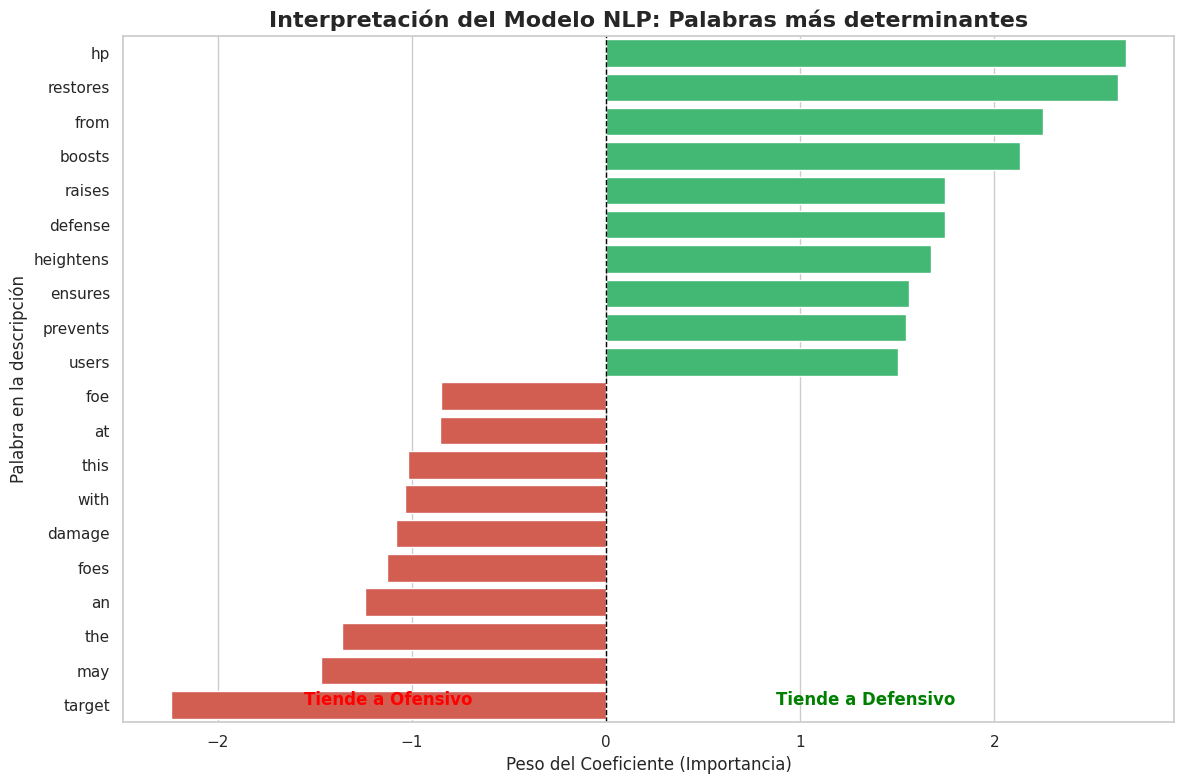

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Extraer el vocabulario y los coeficientes del modelo entrenado
feature_names = vectorizer.get_feature_names_out()
coefs = model.coef_.flatten()

# 2. Crear un DataFrame para facilitar el manejo
df_coefs = pd.DataFrame({'word': feature_names, 'coef': coefs})

# 3. Filtrar las palabras más influyentes
# Las top 10 positivas (indican Defensivo)
top_positive = df_coefs.nlargest(10, 'coef')
# Las top 10 negativas (indican No Defensivo/Ofensivo)
top_negative = df_coefs.nsmallest(10, 'coef')

# Unimos ambos grupos para una sola gráfica
df_plot = pd.concat([top_positive, top_negative]).sort_values('coef', ascending=False)

# 4. Configurar la visualización
plt.figure(figsize=(12, 8))
# Colores: Verde para palabras defensivas, Rojo para no defensivas
colors = ['#2ecc71' if c > 0 else '#e74c3c' for c in df_plot['coef']]

sns.barplot(x='coef', y='word', data=df_plot, palette=colors)

# Decoración
plt.title('Interpretación del Modelo NLP: Palabras más determinantes', fontsize=16, fontweight='bold')
plt.xlabel('Peso del Coeficiente (Importancia)', fontsize=12)
plt.ylabel('Palabra en la descripción', fontsize=12)
plt.axvline(x=0, color='black', linestyle='--', linewidth=1) # Línea central divisoria

# Añadir etiquetas de "Defensivo" vs "Ofensivo" en el gráfico
plt.text(x=max(df_plot['coef'])/2, y=len(df_plot)-1, s="Tiende a Defensivo",
         fontsize=12, color='green', fontweight='bold', ha='center')
plt.text(x=min(df_plot['coef'])/2, y=len(df_plot)-1, s="Tiende a Ofensivo",
         fontsize=12, color='red', fontweight='bold', ha='center')

plt.tight_layout()
plt.show()